In [1]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import tensorflow as tf
print(tf.__version__)

2.4.0


In [42]:
#stopwords

#import nltk
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashwi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#load data
df = pd.read_csv("C:/Users/ashwi/CASTTech-object-tracking/multi-class-classification-author-identify-data/unzip_data/train.csv")

In [3]:
#first 10 number of observations
df.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


In [4]:
#number of observations
len(df)

19579

In [7]:
#number of classes
output_label=list(df['author'])
labels_count={i:output_label.count(i) for i in output_label}
print(labels_count)

{'EAP': 7900, 'HPL': 5635, 'MWS': 6044}


In [8]:
#converting to lowercase
df["text"]=df["text"].str.lower()

In [11]:
#longest text
len(sorted(df["text"],key=len)[-1].split(' '))

861

In [52]:
#import nltk
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashwi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [54]:
#import nltk
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashwi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [14]:
#lemmatization
def getLemmText(text):
    tokens=word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
df['text'] = list(map(getLemmText,df['text']))

In [15]:
#stemming
def getStemmText(text):
    tokens=word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)
df['text'] = list(map(getStemmText,df['text']))

In [16]:
#longest text after lemmatization and stemming
len(sorted(df["text"],key=len)[-1].split(' '))

876

In [17]:
#parameters
EMBEDDING_DIMENSION = 64
VOCABULARY_SIZE = 2000
MAX_LENGTH = 100
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [18]:
#train validation split
xtrain, xtest, ytrain, ytest = train_test_split(df['text'], df['author'], test_size=0.33, random_state=53)

In [19]:
#bag of words
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(xtrain) + list(xtest))

In [22]:
#convertin text to numerical form
xtrain_sequences = tokenizer.texts_to_sequences(xtrain)
xtest_sequences = tokenizer.texts_to_sequences(xtest)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 15762


In [23]:
#padding
xtrain_pad = sequence.pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xtest_pad = sequence.pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)

In [28]:
#bag of words for class labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(list(ytrain))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(ytrain))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(ytest))
print(training_label_seq.shape)

(13117, 1)


In [30]:
#model initialising
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [33]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1008832   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [31]:
#model training
num_epochs = 10
history = model.fit(xtrain_pad, training_label_seq, epochs=num_epochs, validation_data=(xtest_pad, test_label_seq), verbose=2)

Epoch 1/10
410/410 - 302s - loss: 1.2837 - accuracy: 0.3662 - val_loss: 1.0363 - val_accuracy: 0.4933
Epoch 2/10
410/410 - 112s - loss: 0.9711 - accuracy: 0.5417 - val_loss: 0.7037 - val_accuracy: 0.7204
Epoch 3/10
410/410 - 136s - loss: 0.7462 - accuracy: 0.7124 - val_loss: 0.5843 - val_accuracy: 0.7632
Epoch 4/10
410/410 - 147s - loss: 0.6471 - accuracy: 0.7645 - val_loss: 0.5639 - val_accuracy: 0.7868
Epoch 5/10
410/410 - 139s - loss: 0.6078 - accuracy: 0.7826 - val_loss: 0.5628 - val_accuracy: 0.7857
Epoch 6/10
410/410 - 138s - loss: 0.5690 - accuracy: 0.8018 - val_loss: 0.6071 - val_accuracy: 0.7787
Epoch 7/10
410/410 - 137s - loss: 0.5398 - accuracy: 0.8110 - val_loss: 0.5782 - val_accuracy: 0.7809
Epoch 8/10
410/410 - 129s - loss: 0.5039 - accuracy: 0.8216 - val_loss: 0.5951 - val_accuracy: 0.7782
Epoch 9/10
410/410 - 132s - loss: 0.4846 - accuracy: 0.8317 - val_loss: 0.5798 - val_accuracy: 0.7795
Epoch 10/10
410/410 - 132s - loss: 0.4796 - accuracy: 0.8377 - val_loss: 0.6785 - 

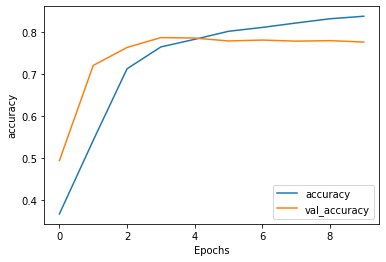

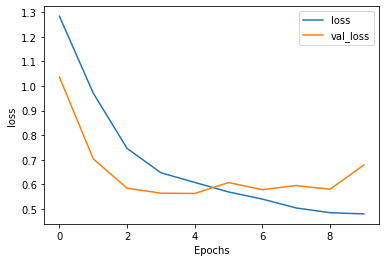

In [32]:
#plotting model history
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
graph_plots(history, "accuracy")
graph_plots(history, "loss")
